In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Summarize data

#### 1.1 Load and prepare data

In [2]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Handle incomplete responses.
data['missing'] = data.accuracy.isnull().astype(int)
data['accuracy'] = data.accuracy.fillna(0)
data['rt'] = data.rt.fillna(30)

## Format data.
data['logrt'] = np.log(data.rt)

#### 1.2 Summarize data

In [3]:
## Summarize dataset.
print('Summary')
print('N trial = %s' %data.shape[0])
print('N subj  = %s' %data.subject.nunique())
print('N item  = %s' %data.item.nunique())

## Quality metrics.
print('\nQuality')
print('Missing: %0.2f%%' %(data.missing.mean() * 100))
print('Rapid:   %0.2f%%' %((data.rt < 3).mean() * 100))

Summary
N trial = 24016
N subj  = 1501
N item  = 64

Quality
Missing: 1.75%
Rapid:   1.08%


#### 1.3 Stratification

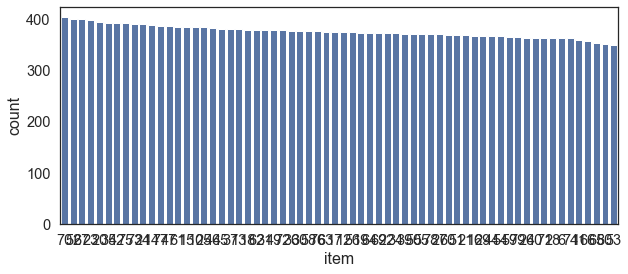

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,4))
order = data.item.value_counts().sort_values(ascending=False).index

sns.countplot(x='item', data=data, order=order, color='#4c72b0', ax=ax);

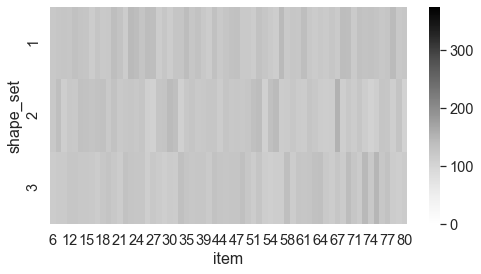

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

pivot = data.pivot_table('trial', 'shape_set', 'item', aggfunc='count')

vmax = data.subject.nunique() * 0.25
sns.heatmap(pivot, vmin=0, vmax=vmax, center=vmax/2, cmap='Greys', ax=ax);

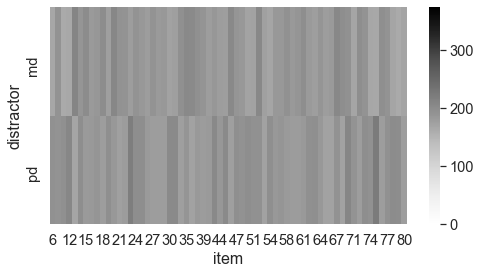

In [6]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

pivot = data.pivot_table('trial', 'distractor', 'item', aggfunc='count').fillna(0)

vmax = data.subject.nunique() * 0.25
sns.heatmap(pivot, vmin=0, vmax=vmax, center=vmax/2, cmap='Greys', ax=ax);

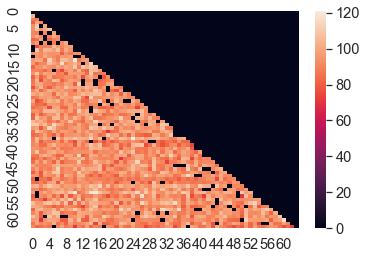

In [7]:
from itertools import combinations

n_item = data.item.nunique()
counts = np.zeros((n_item,n_item))
data['id'] = np.unique(data.item, return_inverse=True)[-1]

for subject in data.subject.unique():

    ## Extract item set.
    items = np.unique(data.query(f'subject == "{subject}"').id)
    
    ## Iteratively tally.
    for i, j in combinations(items, 2): counts[j,i] += 1
        
sns.heatmap(counts);

## Section 2: Behavior

#### 2.1 Item accuracy

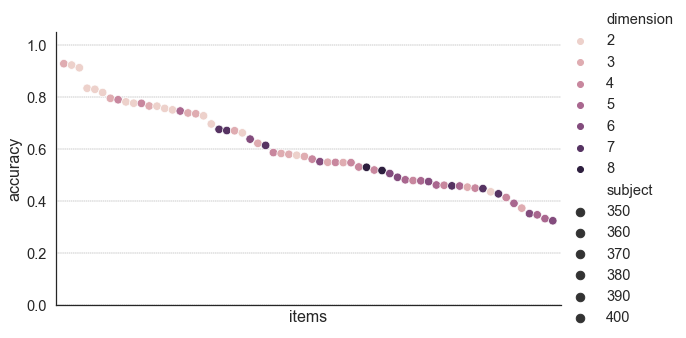

In [8]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))

## Compute summary statistics.
gb = data.groupby('item').agg({'subject':'count','accuracy':'mean','dimension':'mean'})
gb = gb.loc[gb.accuracy.sort_values(ascending=False).index]
n_item = gb.shape[0]

## Plot accuracy.
sns.scatterplot(x=np.arange(n_item), y=gb.accuracy, hue=gb.dimension, size=gb.subject, 
                data=gb, size_norm=(70,120), ax=ax)
ax.grid(axis='y', color='0.5', lw=0.4, linestyle='--', zorder=-1)


## Add details.
ax.set(xlim=(-1, n_item), xticks=[], xlabel='items', ylim=(0,1.05), ylabel='accuracy')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), frameon=False)

sns.despine()
plt.tight_layout()

#### 2.2 Accuracy by dimension

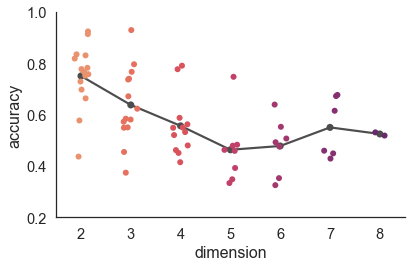

In [9]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))
palette = sns.color_palette('flare', n_colors=data.dimension.nunique())

## Compute item accuracy by test form.
gb = data.groupby(['item','dimension']).accuracy.mean().reset_index()

## Plot accuracy.
sns.pointplot(x='dimension', y='accuracy', data=gb, color='0.3', scale=0.8, ci=None, zorder=-1, ax=ax)
sns.stripplot(x='dimension', y='accuracy', data=gb, palette=palette, size=6, jitter=0.15, ax=ax)

## Add detail.
ax.set(xlabel='dimension', ylim=(0.2,1), ylabel='accuracy')

sns.despine()
plt.tight_layout()

#### 2.3 Accuracy by test form

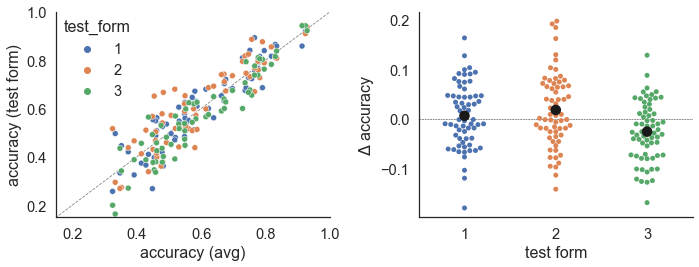

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=3)

## Compute item accuracy by shape set.
gb = data.pivot_table('accuracy','item','test_form')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='test_form', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (test form)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='test_form')

## Plot accuracy.
sns.swarmplot(x='test_form', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='test_form', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='test form', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 2.4 Accuracy by shape set

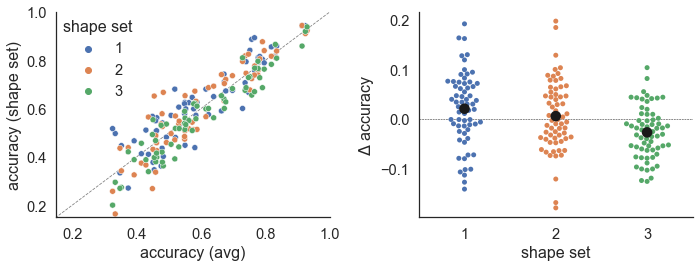

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=3)

## Compute item accuracy by shape set.
gb = data.pivot_table('accuracy','item','shape_set')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='shape_set', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (shape set)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='shape set')

## Plot accuracy.
sns.swarmplot(x='shape_set', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='shape_set', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='shape set', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 2.5 Accuracy by distractor

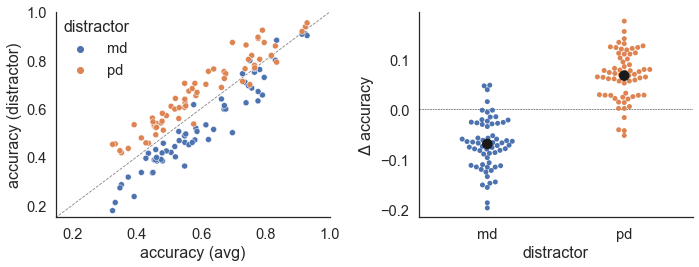

In [12]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=2)

## Compute item accuracy by test form.
gb = data.pivot_table('accuracy', 'item', 'distractor')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='distractor', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (distractor)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='distractor')

## Plot accuracy.
sns.swarmplot(x='distractor', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='distractor', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='distractor', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 2.6 Accuracy by RT

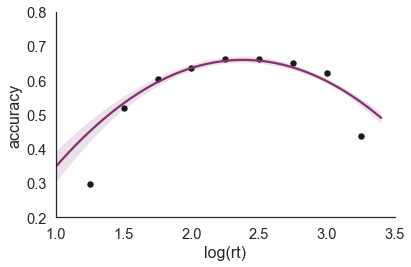

In [13]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Digitize RTs.
data['drt'] = np.digitize(data.logrt, np.arange(1.5, 3.5, 0.25))
data['drt'] = data.drt.replace({i:j for i, j in enumerate(np.arange(1.25,3.50,0.25))})

## Compute average accuracy by binned RT.
gb = data.groupby(['drt']).accuracy.mean().reset_index()

## Plot accuracy ~ logrt polynomial regression.
sns.regplot(x='logrt', y='accuracy', data=data, color='#863071', order=2, scatter=False, ax=ax)

## Plot observations.
sns.scatterplot(x='drt', y='accuracy', data=gb, s=50, color='k', ax=ax)

## Add detail.
ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
ax.set(xlim=(1, 3.5), xlabel='log(rt)', ylim=(0.2,0.8))

sns.despine()
plt.tight_layout()

## Section 3: Consistency

#### 3.1 Item accuracy

In [14]:
## Load and prepare original data summary.
stats = read_csv(os.path.join('data','stats.csv'))
stats = stats.query('Group=="total" and N >= 200')
stats = stats[['Item','Mean.correct']].rename(columns={'Item':'item','Mean.correct':'correct'})

## Compute accuracy by item.
gb = data.groupby('item').accuracy.mean().reset_index()
gb = gb.merge(stats, on='item')

## Compute consistency.
gb[['correct','accuracy']].corr(method='spearman')

,correct,accuracy
correct,1.000000,0.870453
accuracy,0.870453,1.000000
